# Football Match Prediction Model v1

This notebook develops the first machine learning model for football match outcome prediction using the master dataset.

## Objectives:
- Load the master dataset with comprehensive match features
- Perform exploratory data analysis and feature engineering
- Build and evaluate prediction models
- Compare different algorithms and approaches
- Generate predictions and model insights

## Dataset Features:
- Match statistics (possession, shots, passes, etc.)
- Team wage information and squad details
- Historical form metrics (rolling 5-match averages)
- Rest days and contextual match information
- Both team and opponent perspectives

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_selection import mutual_info_classif, f_classif
from scipy.stats import pearsonr,ranksums

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette("husl")

print("✓ Libraries imported successfully")

c:\Users\50230\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


✓ Libraries imported successfully


In [2]:
# Set up paths
project_root = Path().resolve().parent.parent.parent
data_masters = project_root / 'data' / 'prod' / 'processed' / 'masters'
models_dir = project_root / 'models' / 'premier_league'

# Create models directory if it doesn't exist
models_dir.mkdir(parents=True, exist_ok=True)

print(f"Project root: {project_root}")
print(f"Masters data: {data_masters}")
print(f"Models directory: {models_dir}")

Project root: C:\Users\50230\OneDrive\Escritorio\Proyectos y trabajos\Personales\Pronósticos Football
Masters data: C:\Users\50230\OneDrive\Escritorio\Proyectos y trabajos\Personales\Pronósticos Football\data\prod\processed\masters
Models directory: C:\Users\50230\OneDrive\Escritorio\Proyectos y trabajos\Personales\Pronósticos Football\models\premier_league


## Data Loading

Load the master dataset created in the data engineering phase.

In [3]:
# Load master dataset (prefer parquet for efficiency)
dataset_file = data_masters / 'match_stats_master_complete_v1.parquet'

if dataset_file.exists():
    df = pd.read_parquet(dataset_file)
    print(f"✓ Dataset loaded successfully")
    print(f"  Shape: {df.shape}")
    print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
else:
    print("✗ Master dataset not found. Please run master_creation_v1.ipynb first.")
    df = None

✓ Dataset loaded successfully
  Shape: (5711, 258)
  Memory usage: 15.7 MB


## Feature Dropping

In [4]:
id_cols = [
    'date',
    'comp',
    'round',
    'season',
    'team_id',
    'full_match_report_url',
    'team_name',
    'opponent',
    'opponent_id',
    
]

match_cols = [
    'referee',
    'start_time',
    'dayofweek'
]

target_cols = [
    'result',
]

stats_team_A = [
    'venue',
    'Aerials Won_favor_form_avg',
    'Aerials Won_favor_form_sum',
    'Clearances_favor_form_avg',
    'Clearances_favor_form_sum',
    'Corners_favor_form_avg',
    'Corners_favor_form_sum',
    'Crosses_favor_form_avg',
    'Crosses_favor_form_sum',
    'Fouls_favor_form_avg',
    'Fouls_favor_form_sum',
    'Goal Kicks_favor_form_avg',
    'Goal Kicks_favor_form_sum',
    'Interceptions_favor_form_avg',
    'Interceptions_favor_form_sum',
    'Long Balls_favor_form_avg',
    'Long Balls_favor_form_sum',
    'Offsides_favor_form_avg',
    'Offsides_favor_form_sum',
    'Passing Accuracy_favor_form_avg',
    'Passing Accuracy_favor_form_sum',
    'Possession_favor_form_avg',
    'Possession_favor_form_sum',
    'Saves_favor_form_avg',
    'Saves_favor_form_sum',
    'Shots on Target_favor_form_avg',
    'Shots on Target_favor_form_sum',
    'Tackles_favor_form_avg',
    'Tackles_favor_form_sum',
    'Throw Ins_favor_form_avg',
    'Throw Ins_favor_form_sum',
    'Touches_favor_form_avg',
    'Touches_favor_form_sum',
    'Aerials Won_against_form_avg',
    'Aerials Won_against_form_sum',
    'Clearances_against_form_avg',
    'Clearances_against_form_sum',
    'Corners_against_form_avg',
    'Corners_against_form_sum',
    'Crosses_against_form_avg',
    'Crosses_against_form_sum',
    'Fouls_against_form_avg',
    'Fouls_against_form_sum',
    'Goal Kicks_against_form_avg',
    'Goal Kicks_against_form_sum',
    'Interceptions_against_form_avg',
    'Interceptions_against_form_sum',
    'Long Balls_against_form_avg',
    'Long Balls_against_form_sum',
    'Offsides_against_form_avg',
    'Offsides_against_form_sum',
    'Passing Accuracy_against_form_avg',
    'Passing Accuracy_against_form_sum',
    'Possession_against_form_avg',
    'Possession_against_form_sum',
    'Saves_against_form_avg',
    'Saves_against_form_sum',
    'Shots on Target_against_form_avg',
    'Shots on Target_against_form_sum',
    'Tackles_against_form_avg',
    'Tackles_against_form_sum',
    'Throw Ins_against_form_avg',
    'Throw Ins_against_form_sum',
    'Touches_against_form_avg',
    'Touches_against_form_sum',
    'points_form_avg',
    'points_form_sum',
    'rest_days',
    'rest_days_form_avg',
    'rest_days_form_sum',
    'xg_for_form_avg',
    'xg_for_form_sum',
    'xg_against_form_avg',
    'xg_against_form_sum',
    'goals_for_form_avg',
    'goals_for_form_sum',
    'goals_against_form_avg',
    'goals_against_form_sum'
]

columnas_team_A_validacion = [
    'Aerials Won_favor',
    'Clearances_favor',
    'Corners_favor',
    'Crosses_favor',
    'Fouls_favor',
    'Goal Kicks_favor',
    'Interceptions_favor',
    'Long Balls_favor',
    'Offsides_favor',
    'Passing Accuracy_favor',
    'Possession_favor',
    'Saves_favor',
    'Shots on Target_favor',
    'Tackles_favor',
    'Throw Ins_favor',
    'Touches_favor',
    'Aerials Won_against',
    'Clearances_against',
    'Corners_against',
    'Crosses_against',
    'Fouls_against',
    'Goal Kicks_against',
    'Interceptions_against',
    'Long Balls_against',
    'Offsides_against',
    'Passing Accuracy_against',
    'Possession_against',
    'Saves_against',
    'Shots on Target_against',
    'Tackles_against',
    'Throw Ins_against',
    'Touches_against',
    'points',
    'xg_for',
    'xg_against',
    'goals_for',
    'goals_against'
]

players_team_A = [
    'age_mean',
    'squad_size',
    'age_max',
    'age_min',
    'avg_wage_dollars',
    'total_wage_bill_dollars',
    'max_wage_dollars',
    'min_wage_dollars'
 
]

stats_team_B = [
    'Aerials Won_favor_opponent_form_avg',
    'Aerials Won_favor_opponent_form_sum',
    'Clearances_favor_opponent_form_avg',
    'Clearances_favor_opponent_form_sum',
    'Corners_favor_opponent_form_avg',
    'Corners_favor_opponent_form_sum',
    'Crosses_favor_opponent_form_avg',
    'Crosses_favor_opponent_form_sum',
    'Fouls_favor_opponent_form_avg',
    'Fouls_favor_opponent_form_sum',
    'Goal Kicks_favor_opponent_form_avg',
    'Goal Kicks_favor_opponent_form_sum',
    'Interceptions_favor_opponent_form_avg',
    'Interceptions_favor_opponent_form_sum',
    'Long Balls_favor_opponent_form_avg',
    'Long Balls_favor_opponent_form_sum',
    'Offsides_favor_opponent_form_avg',
    'Offsides_favor_opponent_form_sum',
    'Passing Accuracy_favor_opponent_form_avg',
    'Passing Accuracy_favor_opponent_form_sum',
    'Possession_favor_opponent_form_avg',
    'Possession_favor_opponent_form_sum',
    'Saves_favor_opponent_form_avg',
    'Saves_favor_opponent_form_sum',
    'Shots on Target_favor_opponent_form_avg',
    'Shots on Target_favor_opponent_form_sum',
    'Tackles_favor_opponent_form_avg',
    'Tackles_favor_opponent_form_sum',
    'Throw Ins_favor_opponent_form_avg',
    'Throw Ins_favor_opponent_form_sum',
    'Touches_favor_opponent_form_avg',
    'Touches_favor_opponent_form_sum',
    'Aerials Won_against_opponent_form_avg',
    'Aerials Won_against_opponent_form_sum',
    'Clearances_against_opponent_form_avg',
    'Clearances_against_opponent_form_sum',
    'Corners_against_opponent_form_avg',
    'Corners_against_opponent_form_sum',
    'Crosses_against_opponent_form_avg',
    'Crosses_against_opponent_form_sum',
    'Fouls_against_opponent_form_avg',
    'Fouls_against_opponent_form_sum',
    'Goal Kicks_against_opponent_form_avg',
    'Goal Kicks_against_opponent_form_sum',
    'Interceptions_against_opponent_form_avg',
    'Interceptions_against_opponent_form_sum',
    'Long Balls_against_opponent_form_avg',
    'Long Balls_against_opponent_form_sum',
    'Offsides_against_opponent_form_avg',
    'Offsides_against_opponent_form_sum',
    'Passing Accuracy_against_opponent_form_avg',
    'Passing Accuracy_against_opponent_form_sum',
    'Possession_against_opponent_form_avg',
    'Possession_against_opponent_form_sum',
    'Saves_against_opponent_form_avg',
    'Saves_against_opponent_form_sum',
    'Shots on Target_against_opponent_form_avg',
    'Shots on Target_against_opponent_form_sum',
    'Tackles_against_opponent_form_avg',
    'Tackles_against_opponent_form_sum',
    'Throw Ins_against_opponent_form_avg',
    'Throw Ins_against_opponent_form_sum',
    'Touches_against_opponent_form_avg',
    'Touches_against_opponent_form_sum',
    'points_opponent_form_avg',
    'points_opponent_form_sum',
    'rest_days_opponent',
    'rest_days_opponent_form_avg',
    'rest_days_opponent_form_sum',
    'xg_for_opponent_form_avg',
    'xg_for_opponent_form_sum',
    'xg_against_opponent_form_avg',
    'xg_against_opponent_form_sum',
    'goals_for_opponent_form_avg',
    'goals_for_opponent_form_sum',
    'goals_against_opponent_form_avg',
    'goals_against_opponent_form_sum'
]

columnas_team_B_validacion = [
    'Aerials Won_favor_opponent',
    'Clearances_favor_opponent',
    'Corners_favor_opponent',
    'Crosses_favor_opponent',
    'Fouls_favor_opponent',
    'Goal Kicks_favor_opponent',
    'Interceptions_favor_opponent',
    'Long Balls_favor_opponent',
    'Offsides_favor_opponent',
    'Passing Accuracy_favor_opponent',
    'Possession_favor_opponent',
    'Saves_favor_opponent',
    'Shots on Target_favor_opponent',
    'Tackles_favor_opponent',
    'Throw Ins_favor_opponent',
    'Touches_favor_opponent',
    'Aerials Won_against_opponent',
    'Clearances_against_opponent',
    'Corners_against_opponent',
    'Crosses_against_opponent',
    'Fouls_against_opponent',
    'Goal Kicks_against_opponent',
    'Interceptions_against_opponent',
    'Long Balls_against_opponent',
    'Offsides_against_opponent',
    'Passing Accuracy_against_opponent',
    'Possession_against_opponent',
    'Saves_against_opponent',
    'Shots on Target_against_opponent',
    'Tackles_against_opponent',
    'Throw Ins_against_opponent',
    'Touches_against_opponent',
    'points_opponent',
    'xg_for_opponent',
    'xg_against_opponent',
    'goals_for_opponent',
    'goals_against_opponent'
]

players_team_B = [
    'opp_age_mean',
    'opp_squad_size',
    'opp_age_max',
    'opp_age_min',
    'opp_avg_wage_dollars',
    'opp_total_wage_bill_dollars',
    'opp_max_wage_dollars',
    'opp_min_wage_dollars'
]

cols_drop = columnas_team_A_validacion + columnas_team_B_validacion

df.drop(cols_drop,axis=1,inplace=True)

## Feature Engineering & Data Preparation

Analyze the dataset structure and target variable distribution.

In [5]:
cols_add_A = [
 'age_mean',
 'squad_size',
 'age_max',
 'age_min',
 'avg_wage_dollars',
 'total_wage_bill_dollars',
 'max_wage_dollars',
 'min_wage_dollars'
]

cols_add_B = [
'opp_age_mean',
 'opp_squad_size',
 'opp_age_max',
 'opp_age_min',
 'opp_avg_wage_dollars',
 'opp_total_wage_bill_dollars',
 'opp_max_wage_dollars',
 'opp_min_wage_dollars' 
]

for columna in range(len(cols_add_A)):
    df[cols_add_A[columna] + '_diff'] = df[cols_add_A[columna]] - df[cols_add_B[columna]]

if df is not None:
    # Basic dataset info
    print("Dataset Overview:")
    print(f"  Rows: {len(df):,}")
    print(f"  Columns: {len(df.columns):,}")
    print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"  Seasons: {sorted(df['season'].unique())}")
    print(f"  Teams: {len(df['team_id'].unique())} unique teams")
    
    # Target variable distribution
    print("\nTarget Variable (Result) Distribution:")
    result_counts = df['result'].value_counts()
    result_pct = df['result'].value_counts(normalize=True) * 100
    
    for result in ['W', 'D', 'L']:
        if result in result_counts:
            print(f"  {result}: {result_counts[result]:,} ({result_pct[result]:.1f}%)")
    
    # Missing values summary
    missing_summary = df.isnull().sum().sort_values(ascending=False)
    missing_pct = (missing_summary / len(df) * 100).round(1)
    
    print(f"\nColumns with missing values (top 10):")
    for col, missing in missing_summary.head(10).items():
        if missing > 0:
            print(f"  {col}: {missing:,} ({missing_pct[col]}%)")

Dataset Overview:
  Rows: 5,711
  Columns: 192
  Date range: 2019-08-04 00:00:00 to 2025-05-28 00:00:00
  Seasons: ['2019-2020', '2020-2021', '2021-2022', '2022-2023', '2023-2024', '2024-2025']
  Teams: 27 unique teams

Target Variable (Result) Distribution:
  W: 2,406 (42.1%)
  D: 1,257 (22.0%)
  L: 2,048 (35.9%)

Columns with missing values (top 10):
  rest_days_opponent_form_sum: 817 (14.3%)
  rest_days_opponent_form_avg: 817 (14.3%)
  xg_against_opponent_form_sum: 796 (13.9%)
  xg_against_opponent_form_avg: 796 (13.9%)
  xg_for_opponent_form_sum: 796 (13.9%)
  xg_for_opponent_form_avg: 796 (13.9%)
  Saves_favor_opponent_form_avg: 794 (13.9%)
  Long Balls_favor_opponent_form_sum: 794 (13.9%)
  Offsides_favor_opponent_form_avg: 794 (13.9%)
  Offsides_favor_opponent_form_sum: 794 (13.9%)


In [6]:
df['dayofweek'] = df['dayofweek'].map({
      'Mon': 'midweek',    
      'Tue': 'midweek',    
      'Wed': 'midweek',    
      'Thu': 'midweek',    
      'Fri': 'Fri',    
      'Sat': 'Sat',    
      'Sun': 'Sun'
})

dummies = pd.get_dummies(
    df['dayofweek'],
    drop_first=False,
    dtype=int
)

df.drop('dayofweek', axis=1, inplace=True)

df = pd.concat([df, dummies], axis=1)

df['venue'] = df['venue'].map({
    'Away': 0,
    'Home': 1,
    'Neutral': 0
})

df['result'] = df['result'].astype('category')

In [7]:
informacion_competencias = pd.get_dummies(
    df['comp'],
    dtype=int
 )

df = pd.concat([df, informacion_competencias], axis=1)

## Feature Selection

### Features a evaluar

In [8]:
id_cols = [
    'date',
    'comp',
    'round',
    'season',
    'team_id',
    'full_match_report_url',
    'team_name',
    'opponent',
    'opponent_id',
    'referee',
    'start_time'
]

features = [
    'Passing Accuracy_against_opponent_form_avg',
    'goals_for_opponent_form_avg',
    'Throw Ins_favor_opponent_form_sum',
    'Passing Accuracy_favor_opponent_form_sum',
    'Saves_against_form_sum',
    'Touches_favor_form_sum',
    'Clearances_against_form_sum',
    'Shots on Target_against_form_sum',
    'Touches_favor_opponent_form_avg',
    'Interceptions_against_opponent_form_avg',
    'rest_days_opponent',
    'xg_against_opponent_form_avg',
    'Aerials Won_favor_opponent_form_sum',
    'goals_against_opponent_form_sum',
    'points_opponent_form_avg',
    'rest_days_form_avg',
    'Community Shield',
    'Corners_favor_form_sum',
    'min_wage_dollars',
    'Sun',
    'Possession_favor_opponent_form_avg',
    'Clearances_against_opponent_form_avg',
    'xg_for_opponent_form_sum',
    'Tackles_against_form_avg',
    'Throw Ins_against_opponent_form_sum',
    'Passing Accuracy_against_form_avg',
    'Goal Kicks_against_form_sum',
    'Fouls_against_opponent_form_avg',
    'Touches_against_form_avg',
    'Tackles_favor_form_avg',
    'Tackles_against_opponent_form_avg',
    'rest_days_opponent_form_sum',
    'Crosses_against_opponent_form_sum',
    'FA Cup',
    'Long Balls_favor_form_avg',
    'Interceptions_against_form_avg',
    'Offsides_against_opponent_form_sum',
    'Interceptions_favor_opponent_form_avg',
    'Throw Ins_favor_form_sum',
    'goals_against_form_sum',
    'goals_for_opponent_form_sum',
    'opp_squad_size',
    'points_form_sum',
    'Europa Lg',
    'Offsides_favor_opponent_form_sum',
    'Corners_favor_opponent_form_sum',
    'age_min',
    'min_wage_dollars_diff',
    'Passing Accuracy_favor_form_sum',
    'Tackles_favor_opponent_form_sum',
    'Possession_favor_opponent_form_sum',
    'total_wage_bill_dollars_diff',
    'Crosses_against_opponent_form_avg',
    'squad_size',
    'Offsides_against_form_avg',
    'xg_against_form_avg',
    'Aerials Won_favor_form_avg',
    'rest_days_opponent_form_avg',
    'points_opponent_form_sum',
    'squad_size_diff',
    'rest_days_form_sum',
    'opp_min_wage_dollars',
    'Corners_against_opponent_form_avg',
    'Offsides_against_opponent_form_avg',
    'Saves_favor_form_sum',
    'Shots on Target_against_opponent_form_avg',
    'Offsides_favor_form_sum',
    'Passing Accuracy_favor_form_avg',
    'Shots on Target_favor_form_avg',
    'Fouls_against_form_avg',
    'Aerials Won_against_opponent_form_avg',
    'Long Balls_against_form_avg',
    'opp_age_min',
    'Clearances_favor_opponent_form_sum',
    'EFL Cup',
    'Touches_against_opponent_form_avg',
    'total_wage_bill_dollars',
    'FA Community Shield',
    'Tackles_favor_form_sum',
    'Offsides_favor_form_avg',
    'goals_against_form_avg',
    'goals_against_opponent_form_avg',
    'Possession_against_opponent_form_avg',
    'Throw Ins_favor_opponent_form_avg',
    'Tackles_against_form_sum',
    'Possession_favor_form_avg',
    'Long Balls_favor_form_sum',
    'Crosses_favor_form_sum',
    'Touches_against_form_sum',
    'Shots on Target_favor_form_sum',
    'rest_days',
    'Clearances_favor_form_sum',
    'Corners_against_opponent_form_sum',
    'Saves_against_form_avg',
    'opp_total_wage_bill_dollars',
    'Touches_favor_opponent_form_sum',
    'Tackles_favor_opponent_form_avg',
    'age_mean_diff',
    'Possession_against_form_avg',
    'age_max',
    'Long Balls_favor_opponent_form_sum',
    'Shots on Target_favor_opponent_form_sum',
    'Premier League',
    'Long Balls_against_opponent_form_avg',
    'Clearances_against_form_avg',
    'xg_against_form_sum',
    'Fouls_favor_form_sum',
    'Goal Kicks_favor_form_avg',
    'Offsides_against_form_sum',
    'opp_max_wage_dollars',
    'Saves_favor_form_avg',
    'Passing Accuracy_favor_opponent_form_avg',
    'Goal Kicks_favor_opponent_form_sum',
    'Throw Ins_against_form_avg',
    'xg_for_form_sum',
    'Aerials Won_against_form_sum',
    'Tackles_against_opponent_form_sum',
    'goals_for_form_avg',
    'Shots on Target_favor_opponent_form_avg',
    'Interceptions_against_form_sum',
    'Corners_favor_form_avg',
    'Crosses_favor_opponent_form_sum',
    'Sat',
    'opp_age_mean',
    'goals_for_form_sum',
    'Goal Kicks_against_opponent_form_avg',
    'Passing Accuracy_against_opponent_form_sum',
    'Possession_against_opponent_form_sum',
    'Aerials Won_against_form_avg',
    'max_wage_dollars_diff',
    'Throw Ins_against_form_sum',
    'Fouls_favor_opponent_form_avg',
    'age_mean',
    'age_max_diff',
    'Saves_against_opponent_form_avg',
    'Possession_favor_form_sum',
    'opp_age_max',
    'Saves_against_opponent_form_sum',
    'Passing Accuracy_against_form_sum',
    'Crosses_favor_opponent_form_avg',
    'xg_for_opponent_form_avg',
    'Interceptions_favor_form_sum',
    'Goal Kicks_against_opponent_form_sum',
    'Corners_against_form_avg',
    'Interceptions_favor_form_avg',
    'Fouls_favor_opponent_form_sum',
    'Interceptions_favor_opponent_form_sum',
    'Throw Ins_against_opponent_form_avg',
    'xg_against_opponent_form_sum',
    'Goal Kicks_favor_form_sum',
    'Throw Ins_favor_form_avg',
    'opp_avg_wage_dollars',
    'Fouls_favor_form_avg',
    'Touches_against_opponent_form_sum',
    'max_wage_dollars',
    'Touches_favor_form_avg',
    'Saves_favor_opponent_form_avg',
    'Champions Lg',
    'Conf Lg',
    'age_min_diff',
    'Goal Kicks_against_form_avg',
    'venue',
    'Shots on Target_against_form_avg',
    'avg_wage_dollars_diff',
    'Fri',
    'Goal Kicks_favor_opponent_form_avg',
    'Offsides_favor_opponent_form_avg',
    'Long Balls_against_opponent_form_sum',
    'Clearances_favor_opponent_form_avg',
    'Long Balls_against_form_sum',
    'xg_for_form_avg',
    'Crosses_against_form_sum',
    'Aerials Won_favor_form_sum',
    'Fouls_against_form_sum',
    'Corners_against_form_sum',
    'Clearances_against_opponent_form_sum',
    'points_form_avg',
    'Aerials Won_against_opponent_form_sum',
    'Fouls_against_opponent_form_sum',
    'Aerials Won_favor_opponent_form_avg',
    'Saves_favor_opponent_form_sum',
    'Clearances_favor_form_avg',
    'Shots on Target_against_opponent_form_sum',
    'Super Cup',
    'Crosses_favor_form_avg',
    'Interceptions_against_opponent_form_sum',
    'Crosses_against_form_avg',
    'Long Balls_favor_opponent_form_avg',
    'avg_wage_dollars',
    'Possession_against_form_sum',
    'Corners_favor_opponent_form_avg',
    'midweek']   

target = [
    'result'
    ]

In [9]:
df['binary_w'] = df['result'].map(
    {
        'W':1,
        'L':0,
        'D':0
    }
)

df['binary_d'] = df['result'].map(
    {
        'W':0,
        'L':0,
        'D':1
    }
)

df['binary_l'] = df['result'].map(
    {
        'W':0,
        'L':1,
        'D':0
    }
)

df_no_nulls = df.dropna()

## Data Preparation for ML

In [10]:
df_train = df[
    df['season']!='2024-2025'
    ]
df_test = df[
    (df['season']=='2024-2025') & 
    (df['comp']=='Premier League')
    ]


X_train = df_train[id_cols + features]
y_train = df_train['result']

X_test = df_test[id_cols + features]
y_test = df_test['result']

## Model Training & Evaluation

Train multiple machine learning models and compare their performance.

In [11]:
# Import LightGBM and optimization libraries
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss
import optuna
from optuna.samplers import TPESampler
import joblib
from datetime import datetime

print("✓ LightGBM and optimization libraries imported successfully")

✓ LightGBM and optimization libraries imported successfully


In [12]:
# Data preparation for LightGBM
print("Preparing data for LightGBM...")

# Handle missing values by filling with median for numerical features
print(f"Missing values before handling: {X_train[features].isnull().sum().sum()}")

# Fill missing values
X_train_clean = X_train[features].fillna(X_train[features].median())
X_test_clean = X_test[features].fillna(X_train[features].median())  # Use training median for test set

print(f"Missing values after handling: {X_train_clean.isnull().sum().sum()}")

# Encode target variable for LightGBM (W=0, D=1, L=2)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print(f"Target encoding: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")
print(f"Training set shape: {X_train_clean.shape}")
print(f"Test set shape: {X_test_clean.shape}")
print(f"Training target distribution: {np.bincount(y_train_encoded)}")
print("✓ Data preparation completed")

Preparing data for LightGBM...
Missing values before handling: 63822
Missing values after handling: 0
Target encoding: {'D': 0, 'L': 1, 'W': 2}
Training set shape: (4758, 192)
Test set shape: (760, 192)
Training target distribution: [1039 1715 2004]
✓ Data preparation completed


In [13]:
# Hyperparameter tuning function with cross-validation
def objective(trial):
    """Objective function for Optuna optimization"""
    
    # Define hyperparameter search space
    params = {
        'objective': 'multiclass',
        'num_class': 3,
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 10, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
        'subsample_for_bin': trial.suggest_int('subsample_for_bin', 200000, 300000),
        'verbose': -1,
        'random_state': 42
    }
    
    # Cross-validation setup
    cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(cv_folds.split(X_train_clean, y_train_encoded)):
        X_fold_train, X_fold_val = X_train_clean.iloc[train_idx], X_train_clean.iloc[val_idx]
        y_fold_train, y_fold_val = y_train_encoded[train_idx], y_train_encoded[val_idx]
        
        # Create LightGBM datasets
        train_data = lgb.Dataset(X_fold_train, label=y_fold_train)
        val_data = lgb.Dataset(X_fold_val, label=y_fold_val, reference=train_data)
        
        # Train model
        model = lgb.train(
            params,
            train_data,
            valid_sets=[val_data],
            num_boost_round=1000,
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
        )
        
        # Predict and calculate accuracy
        y_pred = model.predict(X_fold_val, num_iteration=model.best_iteration)
        y_pred_classes = np.argmax(y_pred, axis=1)
        fold_accuracy = accuracy_score(y_fold_val, y_pred_classes)
        cv_scores.append(fold_accuracy)
    
    # Return mean CV accuracy (Optuna maximizes by default, so we return negative for minimization)
    mean_accuracy = np.mean(cv_scores)
    return mean_accuracy

print("✓ Hyperparameter tuning function created")

✓ Hyperparameter tuning function created


In [14]:
# Run hyperparameter optimization
print("Starting hyperparameter optimization...")
print("This may take several minutes depending on n_trials...")

# Create study
study = optuna.create_study(
    direction='maximize',  # We want to maximize accuracy
    sampler=TPESampler(seed=42)
)

# Optimize hyperparameters
start_time = datetime.now()
study.optimize(objective, n_trials=100, show_progress_bar=True)
end_time = datetime.now()

print(f"\n✓ Optimization completed in {end_time - start_time}")
print(f"Best accuracy: {study.best_value:.4f}")
print("\nBest parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# Save the study for later analysis
study_path = models_dir / 'lgb_optimization_study.joblib'
joblib.dump(study, study_path)
print(f"\n✓ Study saved to: {study_path}")

[I 2025-08-10 08:48:09,337] A new study created in memory with name: no-name-1def24e8-416e-4b89-8f06-49664e0722ec


Starting hyperparameter optimization...
This may take several minutes depending on n_trials...


  0%|          | 0/100 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's multi_logloss: 1.01535
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	valid_0's multi_logloss: 0.998862
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's multi_logloss: 1.00251
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's multi_logloss: 1.01119
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	valid_0's multi_logloss: 0.998503
[I 2025-08-10 08:48:11,858] Trial 0 finished with value: 0.527114315757849 and parameters: {'num_leaves': 118, 'learning_rate': 0.2536999076681772, 'feature_fraction': 0.839196365086843, 'bagging_fraction': 0.759195090518222, 'bagging_freq': 2, 'min_child_samples': 19, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287

In [17]:
# Train final model with best parameters
print("Training final model with optimized parameters...")

# Get best parameters and add fixed parameters
best_params = study.best_params.copy()
best_params.update({
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'verbose': 3,
    'random_state': 42
})

# Create full training dataset
train_data = lgb.Dataset(X_train_clean, label=y_train_encoded)

# Train final model
final_model = lgb.train(
    best_params,
    train_data,
    num_boost_round=1000,
    callbacks=[lgb.log_evaluation(100)]
)

# Save the final model
model_path = models_dir / 'lgb_final_model.joblib'
joblib.dump(final_model, model_path)
print(f"✓ Final model saved to: {model_path}")

# Save feature names and label encoder
joblib.dump(features, models_dir / 'feature_names.joblib')
joblib.dump(label_encoder, models_dir / 'label_encoder.joblib')
print("✓ Feature names and label encoder saved")

Training final model with optimized parameters...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.911990
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.031488
[LightGBM] [Debug] init for col-wise cost 0.000181 seconds, init for row-wise cost 0.003538 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24422
[LightGBM] [Info] Number of data points in the train set: 4758, number of used features: 188
[LightGBM] [Info] Start training from score -1.521569
[LightGBM] [Info] Start training from score -1.020414
[LightGBM] [Info] Start training from score -0.864682
[LightGBM] [Debug] Re-bagging, using 2264 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a t

In [18]:
# Evaluate model on test set
print("Evaluating model on test set...")
print("="*50)

# Make predictions on test set
y_test_pred_proba = final_model.predict(X_test_clean, num_iteration=final_model.best_iteration)
y_test_pred_classes = np.argmax(y_test_pred_proba, axis=1)

# Convert back to original labels
y_test_pred_labels = label_encoder.inverse_transform(y_test_pred_classes)
y_test_true_labels = label_encoder.inverse_transform(y_test_encoded)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test_encoded, y_test_pred_classes)

print(f"🎯 TEST SET ACCURACY: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Cross-validation accuracy: {study.best_value:.4f} ({study.best_value*100:.2f}%)")

# Detailed classification report
print("\n📊 DETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test_true_labels, y_test_pred_labels, 
                          target_names=['Draw', 'Loss', 'Win']))

# Confusion Matrix
print("\n📈 CONFUSION MATRIX:")
cm = confusion_matrix(y_test_true_labels, y_test_pred_labels, labels=['W', 'D', 'L'])
print("     Predicted")
print("     W    D    L")
for i, actual in enumerate(['W', 'D', 'L']):
    print(f"{actual}  {cm[i][0]:3d} {cm[i][1]:3d} {cm[i][2]:3d}")

# Calculate per-class accuracies
print("\n🎯 PER-CLASS ACCURACY:")
for i, class_name in enumerate(['Win', 'Draw', 'Loss']):
    class_accuracy = cm[i, i] / cm[i].sum()
    print(f"  {class_name}: {class_accuracy:.3f} ({class_accuracy*100:.1f}%)")

# Feature importance
print("\n🔍 TOP 20 MOST IMPORTANT FEATURES:")
feature_imp = pd.DataFrame({
    'feature': features,
    'importance': final_model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

for i, row in feature_imp.head(20).iterrows():
    print(f"  {row['feature']}: {row['importance']:.0f}")

# Test set distribution
print(f"\n📋 TEST SET INFO:")
print(f"  Total matches: {len(y_test)}")
print(f"  Wins: {sum(y_test_true_labels == 'W')} ({sum(y_test_true_labels == 'W')/len(y_test)*100:.1f}%)")
print(f"  Draws: {sum(y_test_true_labels == 'D')} ({sum(y_test_true_labels == 'D')/len(y_test)*100:.1f}%)")
print(f"  Losses: {sum(y_test_true_labels == 'L')} ({sum(y_test_true_labels == 'L')/len(y_test)*100:.1f}%)")

print("\n✅ MODEL EVALUATION COMPLETED!")

Evaluating model on test set...
🎯 TEST SET ACCURACY: 0.4921 (49.21%)
Cross-validation accuracy: 0.5586 (55.86%)

📊 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        Draw       0.47      0.05      0.09       186
        Loss       0.49      0.65      0.56       287
         Win       0.50      0.62      0.56       287

    accuracy                           0.49       760
   macro avg       0.49      0.44      0.40       760
weighted avg       0.49      0.49      0.44       760


📈 CONFUSION MATRIX:
     Predicted
     W    D    L
W  179   3 105
D   85   9  92
L   94   7 186

🎯 PER-CLASS ACCURACY:
  Win: 0.624 (62.4%)
  Draw: 0.048 (4.8%)
  Loss: 0.648 (64.8%)

🔍 TOP 20 MOST IMPORTANT FEATURES:
  avg_wage_dollars_diff: 2240
  max_wage_dollars_diff: 1406
  total_wage_bill_dollars_diff: 1085
  min_wage_dollars_diff: 784
  venue: 665
  age_mean_diff: 594
  avg_wage_dollars: 575
  opp_avg_wage_dollars: 553
  Touches_favor_form_avg: 534
  Tackles_

In [25]:
# Función de visualización para LinkedIn en español (ACTUALIZADA - Premier League)
def crear_visualizaciones_linkedin_pl(y_test_true, y_test_pred, y_test_proba, feature_importance_df, 
                                    test_accuracy, cv_accuracy, model_name="LightGBM"):
    """
    Crea visualizaciones profesionales para post de LinkedIn con estilo Premier League
    """
    
    # Configurar estilo profesional
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 16))
    
    # Colores oficiales de la Premier League
    colors = ['#3D195B', '#00FF85', '#E90052', '#37003C', '#04F5FF', '#FFFFFF']
    
    # 1. Matriz de Confusión
    plt.subplot(2, 3, 1)
    cm = confusion_matrix(y_test_true, y_test_pred, labels=['W', 'D', 'L'])
    
    # Usar colormap personalizado Premier League
    from matplotlib.colors import LinearSegmentedColormap
    pl_colors = ['#FFFFFF', '#3D195B']
    pl_cmap = LinearSegmentedColormap.from_list('premier_league', pl_colors)
    
    im = plt.imshow(cm, cmap=pl_cmap, aspect='auto')
    plt.colorbar(im, shrink=0.8)
    plt.title('Matriz de Confusión\nVictoria - Empate - Derrota', 
              fontsize=14, fontweight='bold', pad=20, color='#37003C')
    plt.xlabel('Predicción', fontsize=12, fontweight='bold', color='#37003C')
    plt.ylabel('Resultado Real', fontsize=12, fontweight='bold', color='#37003C')
    
    # Etiquetas en español
    labels_spanish = ['Victoria', 'Empate', 'Derrota']
    plt.xticks([0, 1, 2], labels_spanish, color='#37003C', fontweight='bold')
    plt.yticks([0, 1, 2], labels_spanish, color='#37003C', fontweight='bold')
    
    # Añadir valores en las celdas
    for i in range(3):
        for j in range(3):
            plt.text(j, i, f'{cm[i, j]}', 
                    ha='center', va='center', fontweight='bold',
                    color='white' if cm[i, j] > cm.max()/2 else '#37003C', fontsize=12)
    
    # 2. Distribución de Probabilidades por Clase
    plt.subplot(2, 3, 2)
    
    # Crear violin plot de probabilidades
    prob_data = []
    class_names = ['Victoria', 'Empate', 'Derrota']
    
    for i in range(3):
        prob_data.append(y_test_proba[:, i])
    
    parts = plt.violinplot(prob_data, positions=[1, 2, 3], showmeans=True)
    
    violin_colors = ['#00FF85', '#E90052', '#3D195B']
    for pc, color in zip(parts['bodies'], violin_colors):
        pc.set_facecolor(color)
        pc.set_alpha(0.7)
        pc.set_edgecolor('#37003C')
    
    plt.xlabel('Resultado', fontsize=12, fontweight='bold')
    plt.ylabel('Probabilidad', fontsize=12, fontweight='bold')
    plt.xticks([1, 2, 3], class_names, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # 3. Precisión por Clase
    plt.subplot(2, 3, 3)
    
    # Calcular precisión por clase
    class_accuracies = []
    for i, class_name in enumerate(['W', 'D', 'L']):
        if cm[i].sum() > 0:
            acc = cm[i, i] / cm[i].sum()
            class_accuracies.append(acc * 100)
        else:
            class_accuracies.append(0)
    
    bars = plt.bar(labels_spanish, class_accuracies, color=violin_colors, 
                   alpha=0.8, edgecolor='#37003C', linewidth=2)
    plt.title('Precisión por Tipo de Resultado', fontsize=14, fontweight='bold', 
              pad=20, color='#37003C')
    plt.ylabel('Precisión (%)', fontsize=12, fontweight='bold', color='#37003C')
    plt.ylim(0, 100)
    
    # Añadir valores en las barras
    for bar, value in zip(bars, class_accuracies):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', color='#37003C')
    
    plt.grid(True, alpha=0.3, axis='y', color='#37003C')
    plt.tick_params(colors='#37003C')
    
    # 4. Top 6 Features (Horizontal Bar Chart) - PERSONALIZADO
    plt.subplot(2, 3, 4)
    top_features = feature_importance_df.head(6)  # Solo top 6
    
    # Nombres personalizados de variables
    custom_feature_names = {
        'avg_wage_dollars_diff': 'Diferencia Salarios Promedio',
        'max_wage_dollars_diff': 'Diferencia Salario Máximo', 
        'total_wage_bill_dollars': 'Presupuesto Equipo',
        'min_wage_dollars_diff': 'Diferencia Salarios Mínimos',
        'venue': 'Localía',
        'age_mean_diff': 'Diferencia de Edades en Plantilla'
    }
    
    # Mapear nombres o usar nombres cortos si no están en el diccionario
    feature_names_custom = []
    for feat in top_features['feature']:
        if feat in custom_feature_names:
            feature_names_custom.append(custom_feature_names[feat])
        else:
            # Usar nombre corto si no está en el diccionario personalizado
            short_name = feat.replace('_form_avg', '').replace('_opponent', ' Rival').replace('_favor', ' Favor')
            if len(short_name) > 25:
                short_name = short_name[:22] + '...'
            feature_names_custom.append(short_name)
    
    # Gradiente de colores Premier League para las barras
    bar_colors = ['#3D195B', '#4A2C6B', '#5A3F7B', '#6A528B', '#7A659B', '#8A78AB']
    
    bars = plt.barh(range(len(top_features)), top_features['importance'], 
                    color=bar_colors[:len(top_features)], alpha=0.9, edgecolor='#37003C')
    plt.yticks(range(len(top_features)), feature_names_custom, color='#37003C', fontweight='bold')
    plt.title('Top 6 Variables Más Importantes', fontsize=14, fontweight='bold', 
              pad=20, color='#37003C')
    plt.xlabel('Importancia', fontsize=12, fontweight='bold', color='#37003C')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x', color='#37003C')
    plt.tick_params(colors='#37003C')
    
    # 5. Métricas de Rendimiento Comparativa
    plt.subplot(2, 3, 5)
    
    # Baseline: predicción más frecuente
    from collections import Counter
    most_common = Counter(y_test_true).most_common(1)[0][0]
    baseline_accuracy = Counter(y_test_true)[most_common] / len(y_test_true)
    
    metrics_names = ['Modelo\n(Test)', 'Modelo\n(CV)', 'Baseline\n(Frecuente)', 'Aleatorio']
    metrics_values = [test_accuracy, cv_accuracy, baseline_accuracy, 1/3]
    
    bars = plt.bar(metrics_names, [v*100 for v in metrics_values], 
                   color=['#3D195B', '#00FF85', '#E90052', '#37003C'], 
                   alpha=0.8, edgecolor='#37003C', linewidth=2)
    plt.title('Comparación de Precisión', fontsize=14, fontweight='bold', 
              pad=20, color='#37003C')
    plt.ylabel('Precisión (%)', fontsize=12, fontweight='bold', color='#37003C')
    plt.ylim(0, 100)
    
    # Añadir valores en las barras
    for bar, value in zip(bars, metrics_values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{value*100:.1f}%', ha='center', va='bottom', fontweight='bold', color='#37003C')
    
    plt.grid(True, alpha=0.3, axis='y', color='#37003C')
    plt.tick_params(colors='#37003C')
    
    # 6. Distribución de Predicciones vs Realidad
    plt.subplot(2, 3, 6)
    
    # Contar distribuciones
    real_counts = [list(y_test_true).count(label) for label in ['W', 'D', 'L']]
    pred_counts = [list(y_test_pred).count(label) for label in ['W', 'D', 'L']]
    
    x = np.arange(len(labels_spanish))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, real_counts, width, label='Real', 
                    color='#00FF85', alpha=0.8, edgecolor='#37003C', linewidth=2)
    bars2 = plt.bar(x + width/2, pred_counts, width, label='Predicción', 
                    color='#E90052', alpha=0.8, edgecolor='#37003C', linewidth=2)
    
    plt.title('Distribución: Real vs Predicción', fontsize=14, fontweight='bold', 
              pad=20, color='#37003C')
    plt.xlabel('Tipo de Resultado', fontsize=12, fontweight='bold', color='#37003C')
    plt.ylabel('Cantidad de Partidos', fontsize=12, fontweight='bold', color='#37003C')
    plt.xticks(x, labels_spanish, color='#37003C', fontweight='bold')
    plt.legend(fancybox=True, shadow=True)
    plt.grid(True, alpha=0.3, axis='y', color='#37003C')
    plt.tick_params(colors='#37003C')
    
    # Añadir valores en las barras
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{int(height)}', ha='center', va='bottom', fontweight='bold', 
                    fontsize=10, color='#37003C')
         
    # Fondo blanco
    fig.patch.set_facecolor('white')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    
    # Guardar la imagen en alta resolución para LinkedIn
    output_path = models_dir / 'visualizacion_linkedin_premier_league.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    
    print(f"✅ Visualización Premier League guardada en: {output_path}")
    print("⚽ Con colores oficiales y nombres personalizados!")
    
    plt.show()
    
    return output_path

print("✓ Función de visualización Premier League creada (Top 6 Features + Colores Oficiales)")

✓ Función de visualización Premier League creada (Top 6 Features + Colores Oficiales)



🎨 CREANDO VISUALIZACIONES PREMIER LEAGUE PARA LINKEDIN...
✅ Visualización Premier League guardada en: C:\Users\50230\OneDrive\Escritorio\Proyectos y trabajos\Personales\Pronósticos Football\models\premier_league\visualizacion_linkedin_premier_league.png
⚽ Con colores oficiales y nombres personalizados!


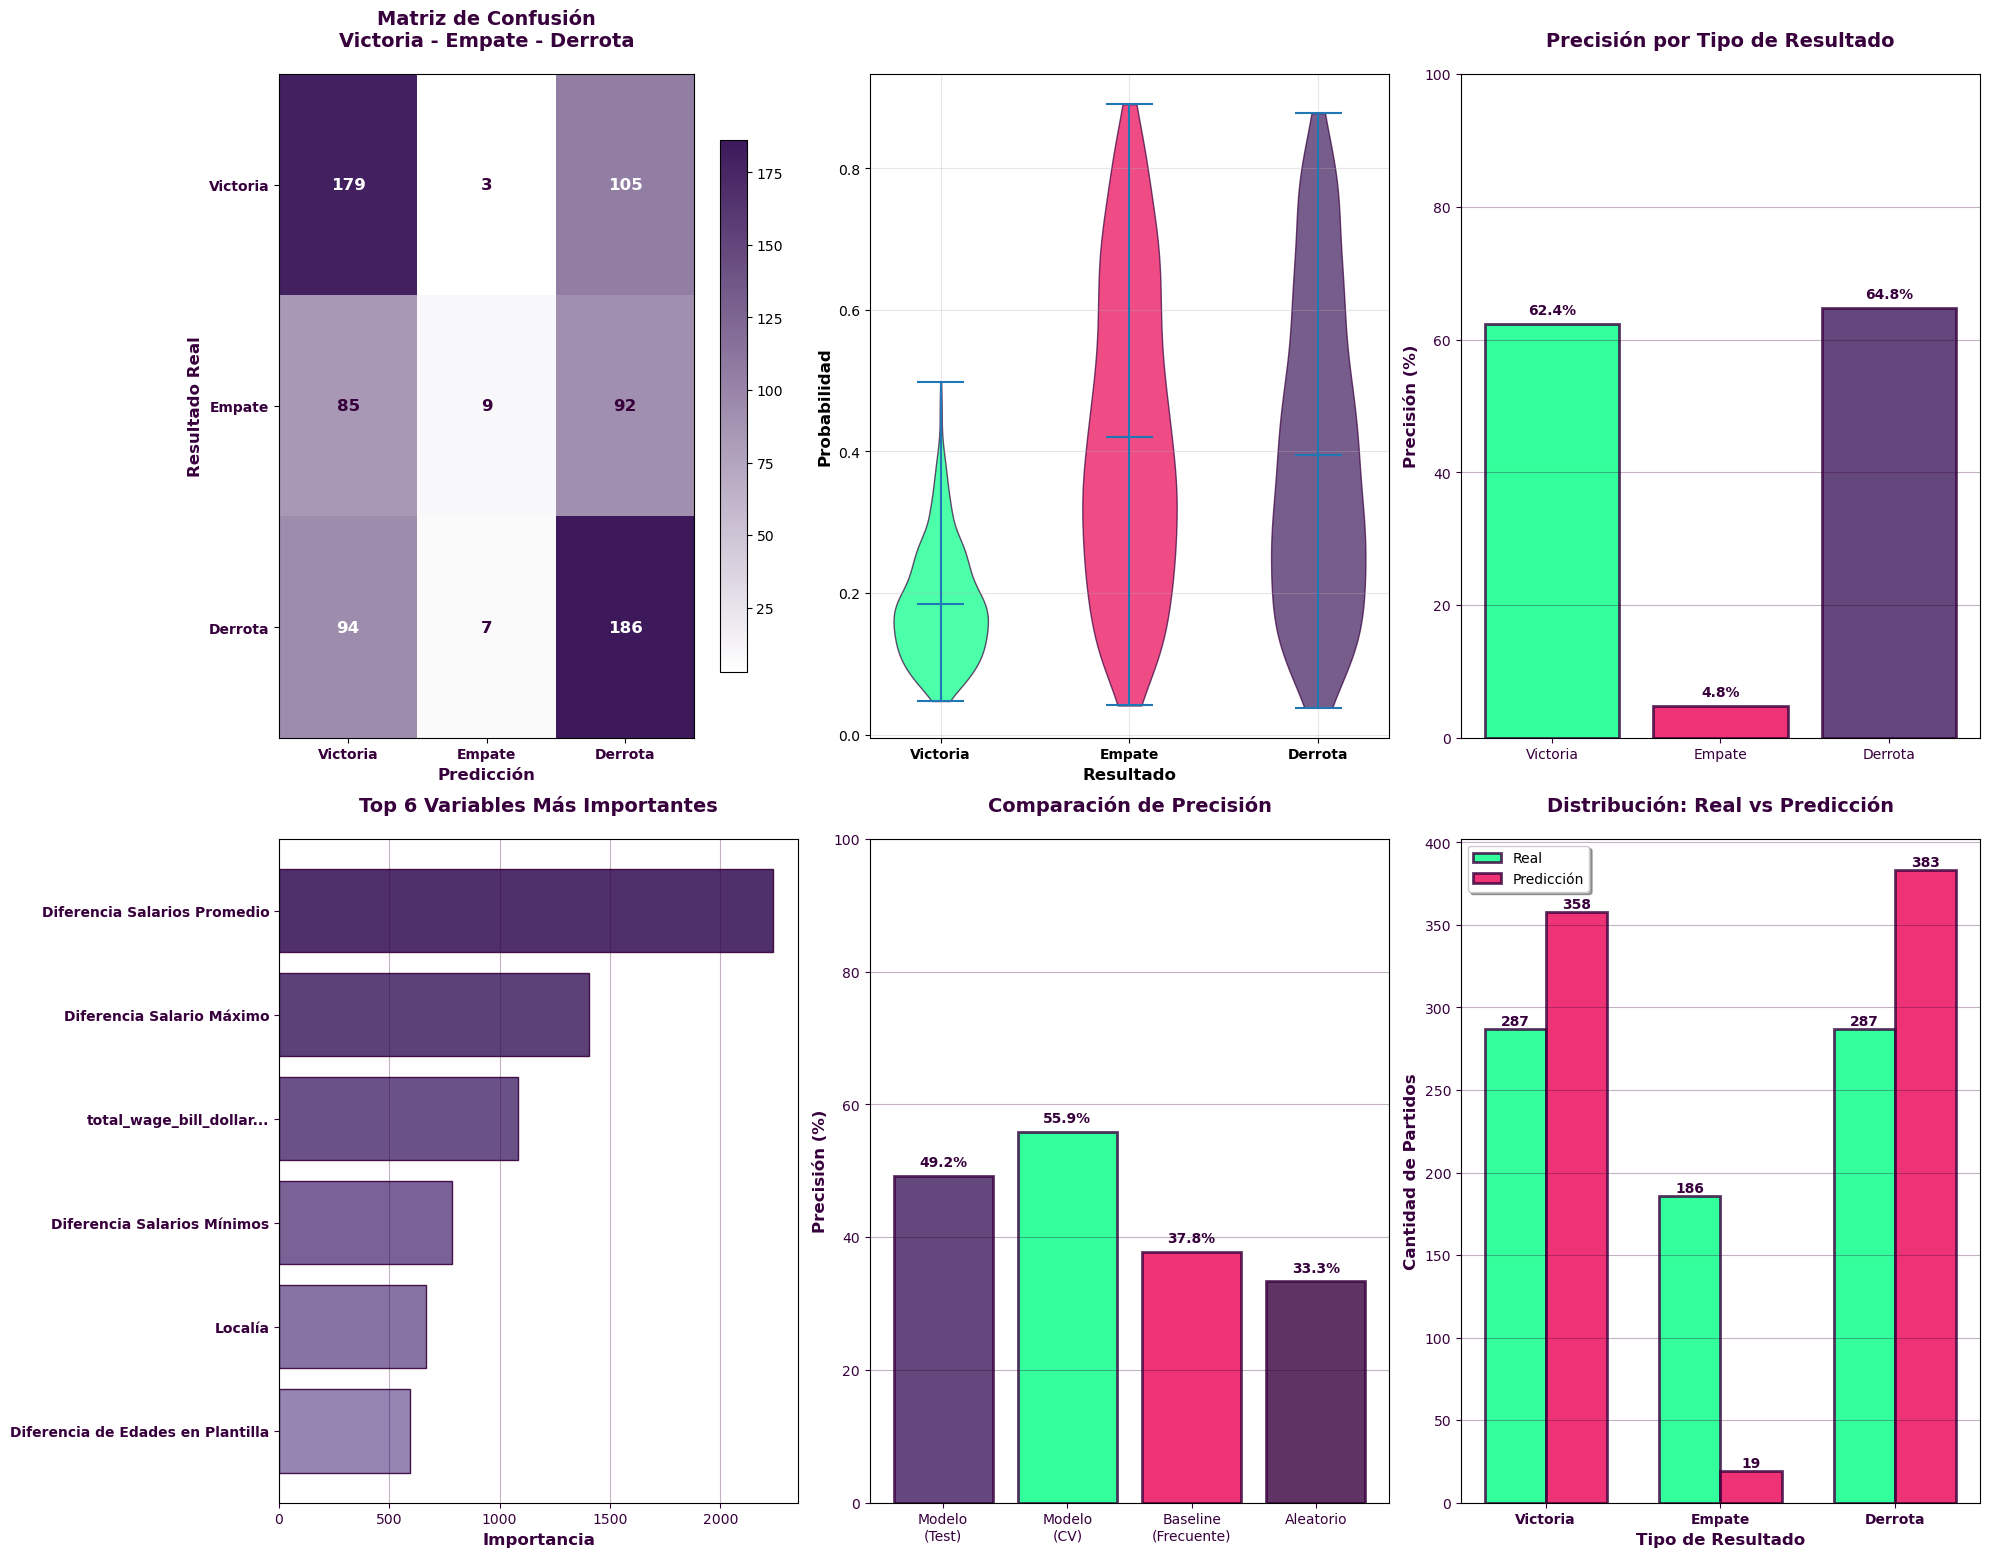


⚽ RESUMEN PREMIER LEAGUE PARA LINKEDIN:
🎯 Modelo: LightGBM con estilo Premier League
📈 Precisión: 49.2% en conjunto de prueba
📊 Validación cruzada: 55.9%
⚽ Partidos analizados: 760 (Premier League 2024-2025)
🏆 Variables clave: Salarios, Localía, Edades
🎨 Colores oficiales Premier League aplicados
📁 Imagen guardada en: C:\Users\50230\OneDrive\Escritorio\Proyectos y trabajos\Personales\Pronósticos Football\models\premier_league\visualizacion_linkedin_premier_league.png

📱 TEXTO SUGERIDO PARA LINKEDIN (PREMIER LEAGUE):

⚽ Predicción de Resultados en Premier League usando Machine Learning 🤖

Desarrollé un modelo predictivo para analizar partidos de la Premier League, enfocándome en factores económicos y estructurales de los equipos.

📊 Resultados del modelo:
✅ Precisión: 49.2% en datos de prueba
✅ Validación cruzada: 55.9%
✅ 760 partidos de Premier League 2024-2025

🔍 Variables más predictivas:
• Diferencia en salarios promedio entre equipos
• Diferencia en salario máximo (estrellas del e

In [26]:
# Llamar a la función de visualización PREMIER LEAGUE después de la evaluación del modelo
print("\n🎨 CREANDO VISUALIZACIONES PREMIER LEAGUE PARA LINKEDIN...")

# Preparar feature importance
feature_imp = pd.DataFrame({
    'feature': features,
    'importance': final_model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

# Crear las visualizaciones con estilo Premier League
output_path_pl = crear_visualizaciones_linkedin_pl(
    y_test_true_labels, 
    y_test_pred_labels, 
    y_test_pred_proba,
    feature_imp,
    test_accuracy,
    study.best_value,
    model_name="LightGBM Premier League"
)

print(f"\n⚽ RESUMEN PREMIER LEAGUE PARA LINKEDIN:")
print(f"🎯 Modelo: LightGBM con estilo Premier League")
print(f"📈 Precisión: {test_accuracy:.1%} en conjunto de prueba")  
print(f"📊 Validación cruzada: {study.best_value:.1%}")
print(f"⚽ Partidos analizados: {len(y_test)} (Premier League 2024-2025)")
print(f"🏆 Variables clave: Salarios, Localía, Edades")
print(f"🎨 Colores oficiales Premier League aplicados")
print(f"📁 Imagen guardada en: {output_path_pl}")

# Texto sugerido para LinkedIn con enfoque en variables económicas
linkedin_text_pl = f"""
⚽ Predicción de Resultados en Premier League usando Machine Learning 🤖

Desarrollé un modelo predictivo para analizar partidos de la Premier League, enfocándome en factores económicos y estructurales de los equipos.

📊 Resultados del modelo:
✅ Precisión: {test_accuracy:.1%} en datos de prueba
✅ Validación cruzada: {study.best_value:.1%}
✅ {len(y_test)} partidos de Premier League 2024-2025

🔍 Variables más predictivas:
• Diferencia en salarios promedio entre equipos
• Diferencia en salario máximo (estrellas del equipo)
• Presupuesto total del equipo
• Localía (ventaja de jugar en casa)
• Diferencia de edades en plantilla

💡 Insight clave: Los factores económicos son altamente predictivos del rendimiento en fútbol. La diferencia salarial entre equipos refleja la calidad de los jugadores y se traduce en resultados en el campo.

El modelo supera significativamente las predicciones aleatorias, demostrando que el "money talks" también en el fútbol.

#PremierLeague #MachineLearning #DataScience #Football #PredictiveAnalytics #Python #LightGBM #SportsAnalytics
"""

print(f"\n📱 TEXTO SUGERIDO PARA LINKEDIN (PREMIER LEAGUE):")
print(linkedin_text_pl)